In [0]:
#SANDBOX_NAME = # Sandbox Name
#DATA_PATH = "/data/sandboxes/"+SANDBOX_NAME+"/data/"



# Workshop de Python

Cargamos datasets con información de admisiones a hospitales de enfermos de diabetes. El objetivo es, una vez limpiado el dataset, estudiarlo para extraer el máximo número de insights de los datos.



## Cargar librerías

In [0]:
%matplotlib inline

import re
import random
import string
from collections import Counter

import pandas as pd
pd.set_option('display.max_colwidth', -1)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest
sns.set(color_codes=True)

#from sklearn.linear_model import LogisticRegression
#from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#from sklearn.cross_validation import train_test_split
#from sklearn.metrics import  roc_curve, auc, silhouette_score, recall_score, precision_score, confusion_matrix, make_scorer
#from sklearn.grid_search import GridSearchCV, ParameterGrid
#from sklearn.cluster import KMeans

from google.colab import drive

drive.mount('/content/drive', force_remount=True)

DATA_PATH = "/content/drive/My Drive/Formación/Data Specialist/Guorchop/Datos_Guorchop/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive




## Lectura de datos

Inspeccionamos los ficheros y comprobamos que el separador utilizado es coma, lo que nos permite hacer la lectura sin especificar el separador


In [0]:
diabetes = pd.read_csv(DATA_PATH+'diabetic_data.csv')
admission_source = pd.read_csv(DATA_PATH+'admission_source_id.csv')
admission_type = pd.read_csv(DATA_PATH+'admission_type_id.csv')
discharge_disposition = pd.read_csv(DATA_PATH+'discharge_disposition_id.csv')




### Comprobar correcta lectura de los datos

#### Cabecera y dimensiones de los dataframes leídos 

In [0]:
print(diabetes.shape)
diabetes.head(5).T

(101766, 50)


,0,1,2,3,4
encounter_id,2278392,149190,64410,500364,16680
patient_nbr,8222157,55629189,86047875,82442376,42519267
race,Caucasian,Caucasian,AfricanAmerican,Caucasian,Caucasian
gender,Female,Female,Female,Male,Male
age,[0-10),[10-20),[20-30),[30-40),[40-50)
weight,?,?,?,?,?
admission_type_id,6,1,1,1,1
discharge_disposition_id,25,1,1,1,1
admission_source_id,1,7,7,7,7
time_in_hospital,1,3,2,2,1


In [0]:
print(admission_source.shape)
admission_source.head()

(25, 2)


,admission_source_id,description
0,1,Physician Referral
1,2,Clinic Referral
2,3,HMO Referral
3,4,Transfer from a hospital
4,5,Transfer from a Skilled Nursing Facility (SNF)


In [0]:
print(admission_type.shape)
admission_type.head()

(8, 2)


,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available


In [0]:
print(discharge_disposition.shape)
discharge_disposition.head()

(30, 2)


,discharge_disposition_id,description
0,1,Discharged to home
1,2,Discharged/transferred to another short term hospital
2,3,Discharged/transferred to SNF
3,4,Discharged/transferred to ICF
4,5,Discharged/transferred to another type of inpatient care institution


Preparamos para juntar todos los datos en un único dataframe: comprobamos que efectivamente hay correspondencia entre campo codificado en df diabetes y campo descrito en las otras tablas

Condición para poder unir en un único dataframe sin ambigüedades: que los códigos utilizados en el dataframe diabetes sean un subconjunto de los utilizados en los ficheros de claves

In [0]:

print('Valores en columna admission_source_id del fichero diabetes son subconjunto de los valores en admission_source: ',set(diabetes['admission_source_id'].unique()).issubset(set(admission_source['admission_source_id'].unique())))
print('Valores en columna admission_type_id del fichero diabetes son subconjunto de los valores en admission_type: ',set(diabetes['admission_type_id'].unique()).issubset(set(admission_type['admission_type_id'].unique())))
print('Valores en columna discharge_disposition_id del fichero diabetes son subconjunto de los valores en discharge_disposition: ',set(diabetes['discharge_disposition_id'].unique()).issubset(set(discharge_disposition['discharge_disposition_id'].unique())))

Valores en columna admission_source_id del fichero diabetes son subconjunto de los valores en admission_source:  True
Valores en columna admission_type_id del fichero diabetes son subconjunto de los valores en admission_type:  True
Valores en columna discharge_disposition_id del fichero diabetes son subconjunto de los valores en discharge_disposition:  True




### Juntar todos los datos en el mismo DataFrame

In [0]:

diabetes_complete = pd.merge(diabetes,admission_source, on=['admission_source_id'], how='left')
diabetes_complete.rename(columns = {'description': 'admission_source_desc'}, inplace=True)
diabetes_complete = pd.merge(diabetes_complete,admission_type, on=['admission_type_id'], how='left')
diabetes_complete.rename(columns = {'description': 'admission_type_desc'}, inplace=True)
diabetes_complete = pd.merge(diabetes_complete,discharge_disposition, on=['discharge_disposition_id'], how='left')
diabetes_complete.rename(columns = {'description': 'discharge_disposition_desc'}, inplace=True)
diabetes_complete.head(5).T

,0,1,2,3,4
encounter_id,2278392,149190,64410,500364,16680
patient_nbr,8222157,55629189,86047875,82442376,42519267
race,Caucasian,Caucasian,AfricanAmerican,Caucasian,Caucasian
gender,Female,Female,Female,Male,Male
age,[0-10),[10-20),[20-30),[30-40),[40-50)
weight,?,?,?,?,?
admission_type_id,6,1,1,1,1
discharge_disposition_id,25,1,1,1,1
admission_source_id,1,7,7,7,7
time_in_hospital,1,3,2,2,1




### Estudiar las dimensiones del dataset

In [0]:
print('Dimensiones del dataset: ',diabetes_complete.shape)
num_records = diabetes_complete.shape[0]
num_vars = diabetes_complete.shape[1]

Dimensiones del dataset:  (101766, 53)
101766 53




## Data Wrangling



### Cambiar los nombres de las columnas para que cumplan buenas prácticas

In [0]:

non_compliant_column_names = list(diabetes_complete.columns)

compliant_column_names = [name.replace(' ','_').replace('-','_').lower() for name in non_compliant_column_names]
diabetes_complete.columns = compliant_column_names
print(diabetes_complete.columns)



Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'a1cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide_metformin', 'glipizide_metformin',
       'glimepiride_pioglitazone', 'metformin_rosiglitazone',
       'metformin_pioglitazone', 'change', 'diabetesmed', 'readmitted',
       'admission_source_desc', 'admission_type_desc',
       'discharge_disposition_desc'],



### Estudiar el formato de las variables, ver cuáles se deberían modificar y modificarlas cuando se considere oportuno

In [0]:
var_types = diabetes_complete.dtypes 
print(var_types)

unique_types = (set(diabetes_complete.dtypes)) # identificamos los tipos únicos en nuestro df

print('Tipos de variables en nuestro dataset: ',unique_types)

# Guardamos en listas separadas los nombres de las columnas que en principio deberían ser numéricas y categóricas
preliminary_num = list(var_types[var_types.values == 'int64'].index)
preliminary_cat = list(var_types[var_types.values == 'O'].index)



encounter_id                  int64 
patient_nbr                   int64 
race                          object
gender                        object
age                           object
weight                        object
admission_type_id             int64 
discharge_disposition_id      int64 
admission_source_id           int64 
time_in_hospital              int64 
payer_code                    object
medical_specialty             object
num_lab_procedures            int64 
num_procedures                int64 
num_medications               int64 
number_outpatient             int64 
number_emergency              int64 
number_inpatient              int64 
diag_1                        object
diag_2                        object
diag_3                        object
number_diagnoses              int64 
max_glu_serum                 object
A1Cresult                     object
metformin                     object
repaglinide                   object
nateglinide                   object
c

In [0]:
print('Tenemos {} variables numéricas y {} variables categóricas'.format(len(preliminary_num),len(preliminary_cat)))

Tenemos 13 variables numéricas y 40 variables categóricas


#### Estudio de las variables que inicialmente se identifican como numéricas

Variables numéricas: buscamos identificar "falsos numéricos" que en realidad son categóricos codificados

In [0]:

print(diabetes_complete[preliminary_num].nunique()) 

encounter_id                101766
patient_nbr                 71518 
admission_type_id           8     
discharge_disposition_id    26    
admission_source_id         17    
time_in_hospital            14    
num_lab_procedures          118   
num_procedures              7     
num_medications             75    
number_outpatient           39    
number_emergency            33    
number_inpatient            21    
number_diagnoses            16    
dtype: int64


La observación de valores únicos por categoría no permite concluir por lo que complementamos con análisis gráfico de la distribución de las variables

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


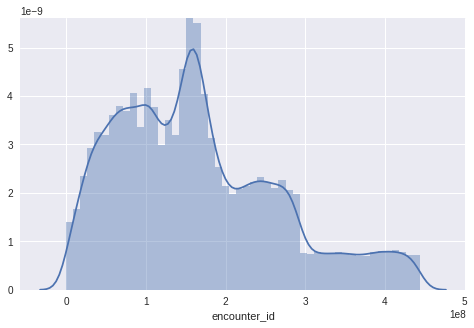

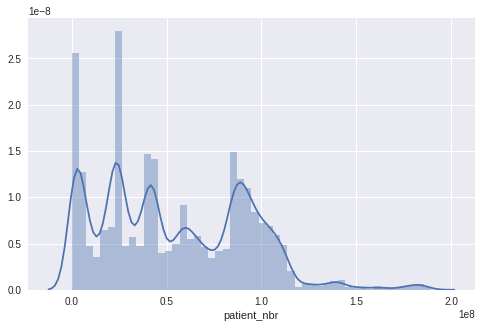

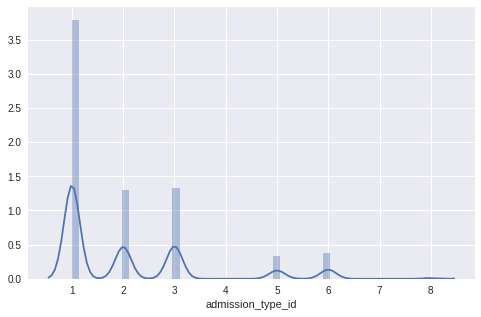

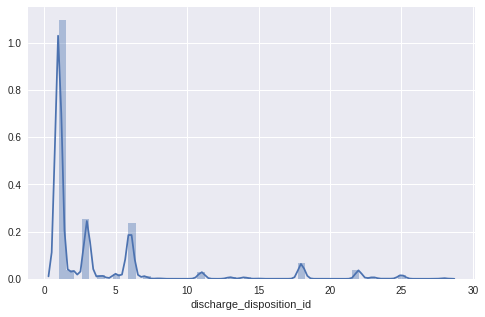

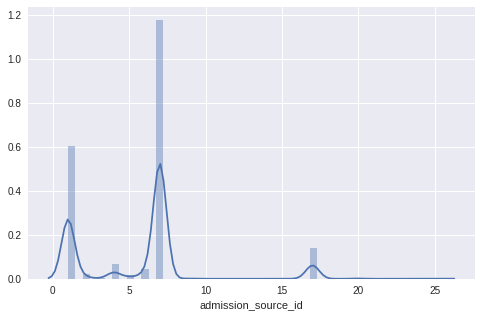

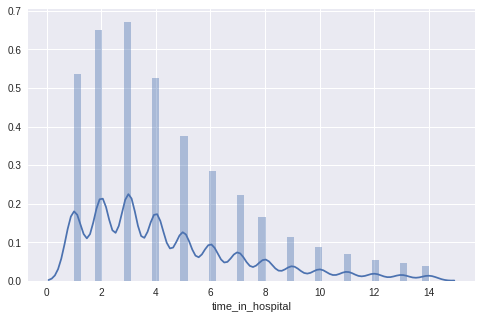

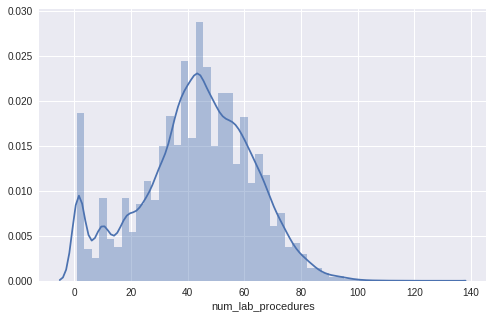

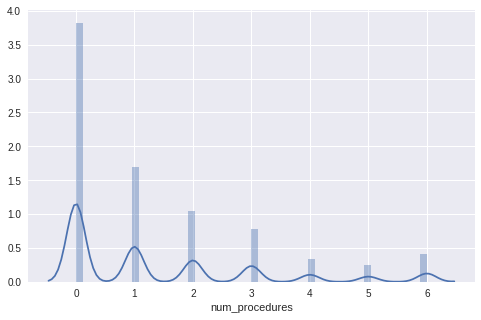

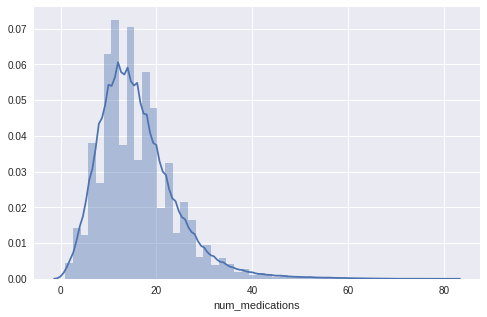

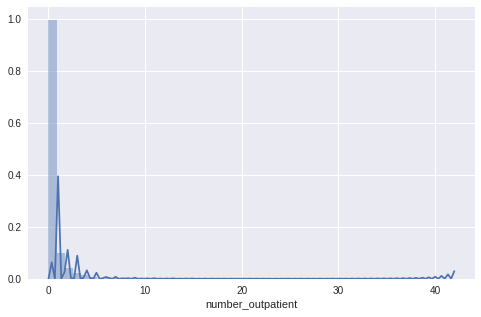

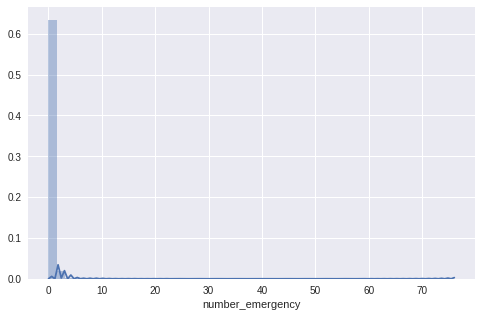

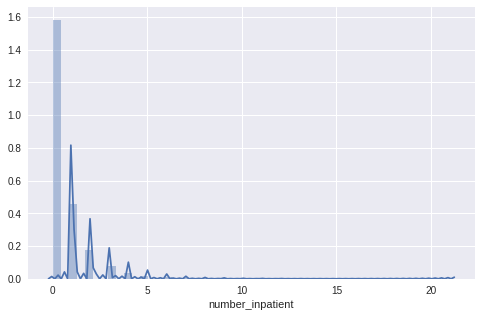

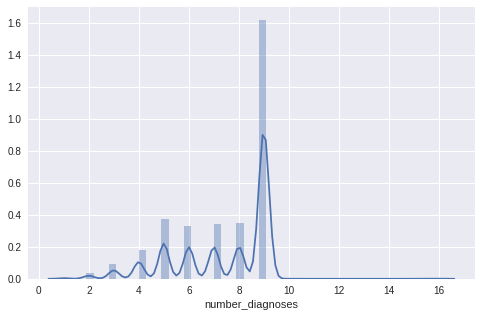

In [0]:
# Lanzamos plots de distribución para todas las variables con un bucle for
for var in preliminary_num:
  plt.figure(figsize=(8, 5))
  sns.distplot(diabetes_complete[var])

Añadimos también un resumen estadístico básico

In [0]:
print(diabetes_complete[preliminary_num].describe())

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


Dada la observacion de la distribución de los cuartiles, trabajamos con la hipótesis de que las variables 'number_outpatient', 'number_emergency' y 'number_inpatient' pudieran ser variables categóricas codificadas numéricamente. Para ello mostramos las listas de valores discretos que toman estas variables

In [0]:

print('Valores registrados de number_emergency: ',diabetes_complete['number_emergency'].unique())
print('Valores registrados de number_outpatient: ',diabetes_complete['number_outpatient'].unique())
print('Valores registrados de number_inpatient: ',diabetes_complete['number_inpatient'].unique())


Valores registrados de number_emergency:  [ 0  1  2  4  3  9  5  7  6  8 22 25 10 13 42 16 11 28 15 14 18 12 21 20
 19 46 76 37 64 63 54 24 29]
Valores registrados de number_outpatient:  [ 0  2  1  5  7  9  3  8  4 12 11  6 20 15 10 13 14 16 21 35 17 29 36 18
 19 27 22 24 42 39 34 26 33 25 23 28 37 38 40]
Valores registrados de number_inpatient:  [ 0  1  2  3  6  5  4  7  8  9 15 10 11 14 12 13 17 16 21 18 19]


Este análisis no nos parece concluyente por el momento

Tras el análisis realizado, decidimos descartar como numéricas todas las variables que terminan en _id y el patient_nbr

In [0]:


definitive_num = [var for var in preliminary_num if (var[-3:]!="_id") & (var != 'patient_nbr')]
num_to_cat = [var for var in preliminary_num if (var[-3:]=="_id") | (var == 'patient_nbr')]
print(definitive_num)
print(num_to_cat)

['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']
['encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id']


Cambiamos el tipo a string de las variables que hemos asignado como categóricas desde numéricas

In [0]:
diabetes_complete[num_to_cat] = diabetes_complete[num_to_cat].applymap(str)

#### Estudio de las variables categóricas


Estudiamos el número de valores distintos que toma cada una de las variables categóricas

In [0]:
print(diabetes_complete[preliminary_cat].nunique())

race                          6  
gender                        3  
age                           10 
weight                        10 
payer_code                    18 
medical_specialty             73 
diag_1                        717
diag_2                        749
diag_3                        790
max_glu_serum                 4  
a1cresult                     4  
metformin                     4  
repaglinide                   4  
nateglinide                   4  
chlorpropamide                4  
glimepiride                   4  
acetohexamide                 2  
glipizide                     4  
glyburide                     4  
tolbutamide                   2  
pioglitazone                  4  
rosiglitazone                 4  
acarbose                      4  
miglitol                      4  
troglitazone                  2  
tolazamide                    3  
examide                       1  
citoglipton                   1  
insulin                       4  
glyburide_metf

La alta dispersión de valores observada nos lleva a sospechar que diag_1, diag_2 y diag_3 pudieran ser en realidad numéricos y los reservamos para continuar su análisis

Con respecto al resto de variables, analizamos la lista de valores discretos que toman para confirmar si tiene sentido o no tratarlas como discretas

In [0]:
for var in preliminary_cat:
  if var not in ('diag_1', 'diag_2', 'diag_3'):
    print('Variable {} , valores únicos: {}'.format(var,diabetes_complete[var].unique()))

Variable race , valores únicos: ['Caucasian' 'AfricanAmerican' '?' 'Other' 'Asian' 'Hispanic']
Variable gender , valores únicos: ['Female' 'Male' 'Unknown/Invalid']
Variable age , valores únicos: ['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']
Variable weight , valores únicos: ['?' '[75-100)' '[50-75)' '[0-25)' '[100-125)' '[25-50)' '[125-150)'
 '[175-200)' '[150-175)' '>200']
Variable payer_code , valores únicos: ['?' 'MC' 'MD' 'HM' 'UN' 'BC' 'SP' 'CP' 'SI' 'DM' 'CM' 'CH' 'PO' 'WC' 'OT'
 'OG' 'MP' 'FR']
Variable medical_specialty , valores únicos: ['Pediatrics-Endocrinology' '?' 'InternalMedicine'
 'Family/GeneralPractice' 'Cardiology' 'Surgery-General' 'Orthopedics'
 'Gastroenterology' 'Surgery-Cardiovascular/Thoracic' 'Nephrology'
 'Orthopedics-Reconstructive' 'Psychiatry' 'Emergency/Trauma'
 'Pulmonology' 'Surgery-Neuro' 'Obsterics&Gynecology-GynecologicOnco'
 'ObstetricsandGynecology' 'Pediatrics' 'Hematology/Oncology'
 'Otola

Con este análisis identificamos: 

1.   Variables que toman sólo 2 valores distintos que probablemente sea conveniente pasar a booleanas
2.   Variables que toman el valor 'None' como categoría de la propia variable, cuando en realidad corresponden a valores nulos y no debería ser una categoría en sí
3.   Hay variables que toman un único valor





Volvemos sobre diag_1, diag_2 y diag_3 para ver qué aspecto toman los datos

In [0]:
print(diabetes_complete['diag_1'].head())
print(diabetes_complete['diag_2'].head())
print(diabetes_complete['diag_3'].head())

0    250.83
1    276   
2    648   
3    8     
4    197   
Name: diag_1, dtype: object
0    ?     
1    250.01
2    250   
3    250.43
4    157   
Name: diag_2, dtype: object
0    ?  
1    255
2    V27
3    403
4    250
Name: diag_3, dtype: object


Como estas variables podrían ser numéricas pero algunos registros tienen lo que parece ser un código en lugar de un registro numérico (ej V57), vamos a crear variables nuevas con una copia de estas en la que limparemos estos datos supuestamente codificados y convertiremos a numérico el resto


Para eso creamos una función de limpieza que luego aplicaremos  a las columnas de nuestro dataframe y almacenaremos su resultado en nuevas variables/columnas

In [0]:

alphabet = list(string.ascii_uppercase) + list(string.ascii_lowercase)
def clean_chars(x):
  # limpia strings de caracteres alfabéticos e ?
  aux = True
  for char in x:
    if (char in alphabet) or (char == '?'):
      result = None
      aux= False
      break
  if aux: result = float(x)
  return result

diabetes_complete['diag_1_num'] = diabetes_complete['diag_1'].apply(clean_chars)
diabetes_complete['diag_2_num'] = diabetes_complete['diag_2'].apply(clean_chars)
diabetes_complete['diag_3_num'] = diabetes_complete['diag_3'].apply(clean_chars)

diabetes_complete.dtypes

  

encounter_id                  object 
patient_nbr                   object 
race                          object 
gender                        object 
age                           object 
weight                        object 
admission_type_id             object 
discharge_disposition_id      object 
admission_source_id           object 
time_in_hospital              int64  
payer_code                    object 
medical_specialty             object 
num_lab_procedures            int64  
num_procedures                int64  
num_medications               int64  
number_outpatient             int64  
number_emergency              int64  
number_inpatient              int64  
diag_1                        object 
diag_2                        object 
diag_3                        object 
number_diagnoses              int64  
max_glu_serum                 object 
A1Cresult                     object 
metformin                     object 
repaglinide                   object 
nateglinide 

Guardamos en una lista los nombres de las nuevas columnas que hemos creado para añadirles posteriormente a nuestro set de variables numéricas

In [0]:
cat_to_num = ['diag_1_num', 'diag_2_num', 'diag_3_num']

Actualizamos las listas de numéricas y categóricas 

In [0]:
definitive_num.extend(cat_to_num)
print(definitive_num)

['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'diag_1_num', 'diag_2_num', 'diag_3_num']


In [0]:

preliminary_cat.extend(num_to_cat)
definitive_cat = preliminary_cat
print(definitive_cat)


['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted', 'admission_source_desc', 'admission_type_desc', 'discharge_disposition_desc', 'encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id']




### Estudiar si hay registros repetidos

No habrá registros repretidos si existe al menos una variable con valores diferentes como registros hay en nuestro dataframe

In [0]:
if (diabetes_complete.nunique().max()== num_records): print('No hay registros duplicados en nuestro dataset')
print(diabetes_complete.duplicated().value_counts())

No hay registros duplicados en nuestro dataset
False    101766
dtype: int64


El identificador de nuestro df es 'encounter id' dado que toma tantos valores distintos como registros. Notamos que existen varios registros por 'patient_nbr' por lo que concluimos que se trata de varias visitas del mismo paciente



### Estudiar si hay variables que siempre o prácticamente siempre toman el mismo valor: tomar siempre el mismo valor no aporta información al modelo

Este análisis lo hemos hecho ya por partes (para variables categóricas y numéricas) pero lo repetimos aquí para el conjunto de las variables, buscando potenciales variables irrelevantes

In [0]:

irrelevant_list = []
for var in diabetes_complete.columns:
  print('Variable {} tiene {} valores únicos'.format(var,diabetes_complete[var].nunique()))
  if diabetes_complete[var].nunique() < 2:
    irrelevant_list.append(var)
print('{} variables irrelevantes encontradas'.format(len(irrelevant_list)))


Variable encounter_id tiene 101766 valores únicos
Variable patient_nbr tiene 71518 valores únicos
Variable race tiene 6 valores únicos
Variable gender tiene 3 valores únicos
Variable age tiene 10 valores únicos
Variable weight tiene 10 valores únicos
Variable admission_type_id tiene 8 valores únicos
Variable discharge_disposition_id tiene 26 valores únicos
Variable admission_source_id tiene 17 valores únicos
Variable time_in_hospital tiene 14 valores únicos
Variable payer_code tiene 18 valores únicos
Variable medical_specialty tiene 73 valores únicos
Variable num_lab_procedures tiene 118 valores únicos
Variable num_procedures tiene 7 valores únicos
Variable num_medications tiene 75 valores únicos
Variable number_outpatient tiene 39 valores únicos
Variable number_emergency tiene 33 valores únicos
Variable number_inpatient tiene 21 valores únicos
Variable diag_1 tiene 717 valores únicos
Variable diag_2 tiene 749 valores únicos
Variable diag_3 tiene 790 valores únicos
Variable number_diag

In [0]:
if len(irrelevant_list):
  print('las variables a borrar son: {}'.format(irrelevant_list))

las variables a borrar son: ['examide', 'citoglipton']


Eliminamos estas variables de nuestro dataset, ya que no aportan nada

In [0]:
diabetes_complete.drop(irrelevant_list, axis=1, inplace=True)
diabetes_complete.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'admission_source_desc', 'admission_type_desc',
       'discharge_disposition_desc', 'diag_1_num', 'diag_2_num', 'diag

Las eliminamos también de nuestra lista de variables categóricas

In [0]:
definitive_cat.remove('examide')
definitive_cat.remove('citoglipton')



### Estudiar los nulos en el dataset

Empezamos con el estudio de nulos per se y luego ampliaremos con valores raros

In [0]:
print('Total de variables del dataframe según si contienen nulos: {}'.format(diabetes_complete.isnull().any().value_counts()))

Total de variables del dataframe según si contienen nulos: False    51
True     3 
dtype: int64


Los nulos se corresponden con las variables que hemos convertido desde numérico dejando en nulo los valores codificados con letras

Analizamos valores atípicos que podrían corresponder a nulos pero que Python no los identifica como tales. Creamos una copia del dataframe en la que sobreescribimos los valores como '?', 'None', 'Unknown/invalid' con nulos

In [0]:
diabetes_complete_clean_with_nulls = diabetes_complete.applymap(lambda x: None if x in ('?', 'None', 'Unknown/Invalid') else x)


Pendiente: gender (unknown/invalid), number_diagnoses (None que no reconoce), max_glu_serum (None que no reconoce) y a1cresult (None que no reconoce)

Repetimos el conteo de nulos sobre esta copia

In [0]:
print('Total de variables del dataframe según si contienen nulos: {}'.format(diabetes_complete_clean_with_nulls.isnull().any().value_counts()))

Total de variables del dataframe según si contienen nulos: False    38
True     16
dtype: int64


Guardamos en una lista los nombres de las columnas que contienen algún nulo por si nos fuera de utilidad luego

In [0]:
vars_with_nulls = list(diabetes_complete.columns[diabetes_complete_clean_with_nulls.isnull().any() > 0])



### Estudiar los outliers

Hacemos un análisis gráfico de la distribución de las variables numéricas con gráficos de tipo box plot

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


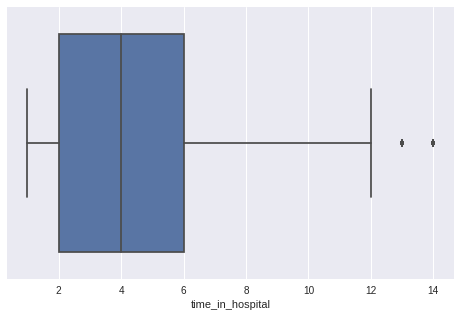

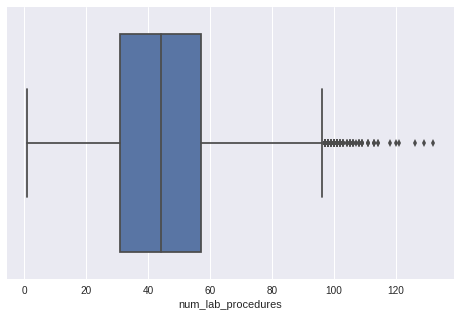

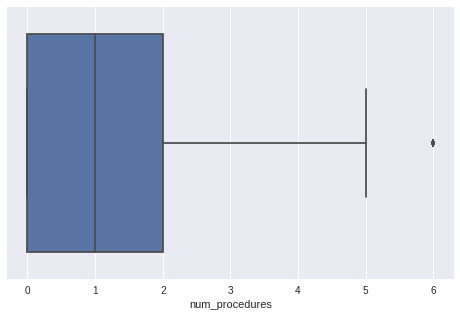

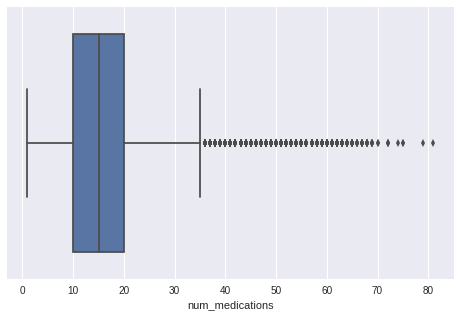

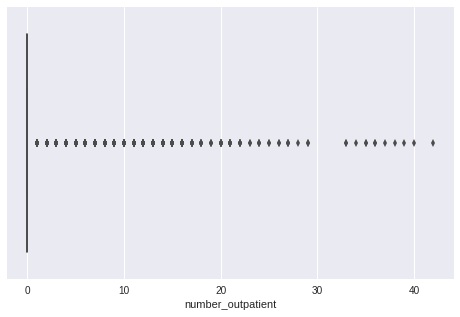

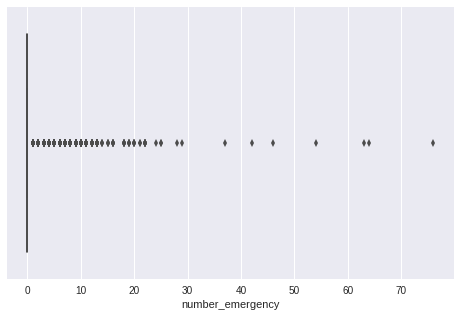

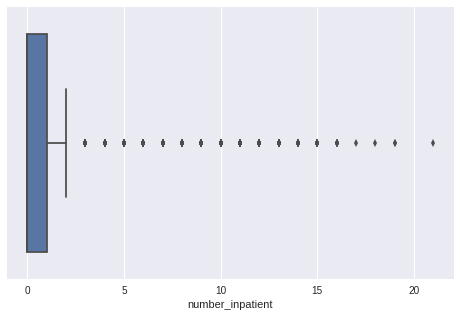

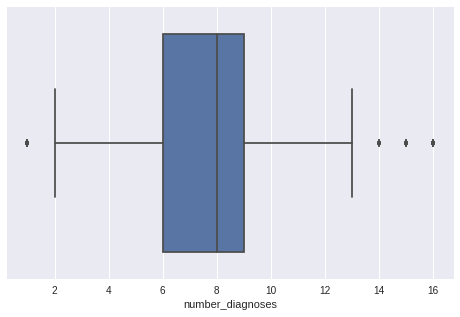

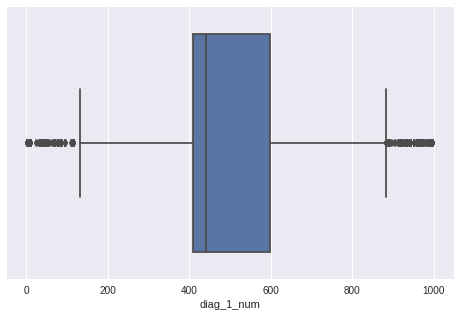

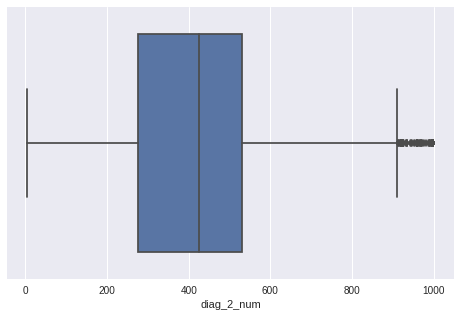

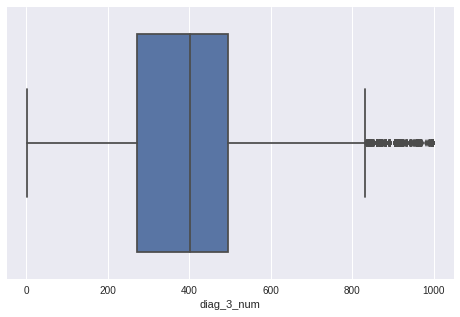

In [0]:

for var in definitive_num:
  plt.figure(figsize=(8, 5))
  sns.boxplot(diabetes_complete[var])

Tras la observación de box plot estimamos que es necesario un análisis en mayor profundidad de las variables nb_outpatient, nb_inpatient y nb_emergency

Podría tratarse de un código que depende de del canal por el que ha llegado el paciente (interno, consulta externa o urgencias) y que tiene los datos no informados a cero. Para confirmar esta hipótesis contamos ceros

In [0]:
print('Registros con number_emergency a cero: {}, {}% del total'.format(len(diabetes_complete[diabetes_complete['number_emergency'] == 0]),len(diabetes_complete[diabetes_complete['number_emergency'] == 0])/num_records*100))
print('Registros con number_inpatient a cero: {}, {}% del total'.format(len(diabetes_complete[diabetes_complete['number_inpatient'] == 0]),len(diabetes_complete[diabetes_complete['number_inpatient'] == 0])/num_records*100))
print('Registros con number_outpatient a cero: {}, {}% del total'.format(len(diabetes_complete[diabetes_complete['number_outpatient'] == 0]),len(diabetes_complete[diabetes_complete['number_outpatient'] == 0])/num_records*100))

Registros con number_emergency a cero: 90383, 88.81453530648743% del total
Registros con number_inpatient a cero: 67630, 66.45638032348722% del total
Registros con number_outpatient a cero: 85027, 83.55148084822042% del total


Como conclusión, decidimos pasar definitivamente a categóricas estas tres variables 

In [0]:
definitive_num.remove('number_emergency')
definitive_num.remove('number_inpatient')
definitive_num.remove('number_outpatient')



In [0]:
definitive_cat.append('number_emergency')
definitive_cat.append('number_inpatient')
definitive_cat.append('number_outpatient')

print(definitive_num)
print(definitive_cat)

['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_diagnoses', 'diag_1_num', 'diag_2_num', 'diag_3_num']
['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted', 'admission_source_desc', 'admission_type_desc', 'discharge_disposition_desc', 'encounter_id', 'patient_nbr', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'number_emergency', 'number_inpatient', 'number_outpatient']


Casteamos el tipo de estas variables a string para mayor limpieza (le pasamos la lista completa de variables categóricas actualizada)

In [0]:
diabetes_complete_clean_with_nulls[definitive_cat]= diabetes_complete_clean_with_nulls[definitive_cat].applymap(str)

Hemos observado que ninguna de las variables parece comportarse como una distribución normal típica (las que mas se aproximan son time_in_hospital y num_lab_procedures). Complementamos el análisis gráfico de outliers con el test estadístico de Tukey

In [0]:
def hay_tukey_outliers(column,extreme=False):
    q1, q3 = np.percentile(column,[25,75])#q1 es 25 y q3 es 75 
    iqr = q3 - q1
    constant = 1.5 if not extreme else 3
    res = False
    i = 0
    for x in column:
      if (x > q3 + constant*iqr) or (x < q1 - constant*iqr):
        i +=1
        res = True 
    return res, i

for col in definitive_num:
  print('Valores outliers extremos en {} : {}'.format(col,hay_tukey_outliers(diabetes_complete_clean_with_nulls[col],True)))
  print('Valores outliers no extremos en {} : {}'.format(col,hay_tukey_outliers(diabetes_complete_clean_with_nulls[col],False)))

Valores outliers extremos en time_in_hospital : (False, 0)
Valores outliers no extremos en time_in_hospital : (True, 2252)
Valores outliers extremos en num_lab_procedures : (False, 0)
Valores outliers no extremos en num_lab_procedures : (True, 143)
Valores outliers extremos en num_procedures : (False, 0)
Valores outliers no extremos en num_procedures : (True, 4954)
Valores outliers extremos en num_medications : (True, 430)
Valores outliers no extremos en num_medications : (True, 2557)
Valores outliers extremos en number_diagnoses : (False, 0)
Valores outliers no extremos en number_diagnoses : (True, 281)
Valores outliers extremos en diag_1_num : (False, 0)
Valores outliers no extremos en diag_1_num : (False, 0)


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


Valores outliers extremos en diag_2_num : (False, 0)
Valores outliers no extremos en diag_2_num : (False, 0)
Valores outliers extremos en diag_3_num : (False, 0)
Valores outliers no extremos en diag_3_num : (False, 0)


Para finalizar el análisis de las variables numéricas, repetimos el análisis descriptivo estadístico de las variables definitivas

In [0]:
diabetes_complete_clean_with_nulls[definitive_num].describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,diag_1_num,diag_2_num,diag_3_num
count,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,100100.00000,98872.000000,95285.000000
mean,4.395987,43.095641,1.339730,16.021844,7.422607,493.58307,438.674883,418.179285
std,2.985108,19.674362,1.705807,8.127566,1.933600,206.71532,178.901638,177.323979
min,1.000000,1.000000,0.000000,1.000000,1.000000,3.00000,5.000000,3.000000
25%,2.000000,31.000000,0.000000,10.000000,6.000000,410.00000,276.000000,272.000000
50%,4.000000,44.000000,1.000000,15.000000,8.000000,440.00000,425.000000,403.000000
75%,6.000000,57.000000,2.000000,20.000000,9.000000,599.00000,530.000000,496.000000
max,14.000000,132.000000,6.000000,81.000000,16.000000,999.00000,999.000000,999.000000


In [0]:
estadisticos = diabetes_complete_clean_with_nulls.describe().loc[['mean', 'std']]
estadisticos.loc['variance'] = estadisticos.loc['std']**2
estadisticos

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,diag_1_num,diag_2_num,diag_3_num
mean,4.395987,43.095641,1.339730,16.021844,7.422607,493.583070,438.674883,418.179285
std,2.985108,19.674362,1.705807,8.127566,1.933600,206.715320,178.901638,177.323979
variance,8.910868,387.080530,2.909777,66.057332,3.738810,42731.223703,32005.795914,31443.793403




### Crear variables dummy en caso que sea conveniente

Candidatos a variables dummy: identificamos aquellas variables categóricas con número de valores distintos superior a 2 e inferior a 5

In [0]:
to_dummies = []
for var in definitive_cat:
  if (diabetes_complete_clean_with_nulls[var].nunique() < 5) and (diabetes_complete_clean_with_nulls[var].nunique() > 2):
    to_dummies.append(var)
to_dummies

['gender',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'glipizide',
 'glyburide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'tolazamide',
 'insulin',
 'glyburide-metformin',
 'readmitted']

Pasarlas a dummy haríamos una copia de estas variables en un df nuevo eliminando los nulos.

In [0]:
diabetes_dummies = diabetes_complete_clean_with_nulls[to_dummies]
diabetes_dummies = diabetes_dummies.dropna()
diabetes_dummies.isnull().any()

gender                 False
max_glu_serum          False
A1Cresult              False
metformin              False
repaglinide            False
nateglinide            False
chlorpropamide         False
glimepiride            False
glipizide              False
glyburide              False
pioglitazone           False
rosiglitazone          False
acarbose               False
miglitol               False
tolazamide             False
insulin                False
glyburide-metformin    False
readmitted             False
dtype: bool

In [0]:

gender_dumies = pd.get_dummies(diabetes_dummies['gender'])
diabetes_dummies = pd.concat([diabetes_dummies,gender_dumies], axis=1)
diabetes_dummies.head()


 

Aunque era nuestra intención, no hemos podido hacerlo en un bucle for para todas las variables en la lista "to_dummies" y lo hemos hecho para un ejemplo



### Estudiar que todas las variables ahora sí tengan el formato y contenido adecuado. si todavía no, arreglarlas.

Mapear a booleanas variables categóricas con solo 2 valores distintos 

In [0]:
to_boolean = []
for var in definitive_cat:
  if (diabetes_complete_clean_with_nulls[var].nunique() == 2):
    to_boolean.append(var)
to_boolean

['acetohexamide',
 'tolbutamide',
 'troglitazone',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'change',
 'diabetesMed']

In [0]:
diabetes_complete_clean_with_nulls[to_boolean] = diabetes_complete_clean_with_nulls[to_boolean].applymap(bool)
print(diabetes_complete_clean_with_nulls[to_boolean].dtypes)

acetohexamide               bool
tolbutamide                 bool
troglitazone                bool
glipizide-metformin         bool
glimepiride-pioglitazone    bool
metformin-rosiglitazone     bool
metformin-pioglitazone      bool
change                      bool
diabetesMed                 bool
dtype: object


In [0]:
print(diabetes_complete_clean_with_nulls.dtypes)

encounter_id                  object 
patient_nbr                   object 
race                          object 
gender                        object 
age                           object 
weight                        object 
admission_type_id             object 
discharge_disposition_id      object 
admission_source_id           object 
time_in_hospital              int64  
payer_code                    object 
medical_specialty             object 
num_lab_procedures            int64  
num_procedures                int64  
num_medications               int64  
number_outpatient             object 
number_emergency              object 
number_inpatient              object 
diag_1                        object 
diag_2                        object 
diag_3                        object 
number_diagnoses              int64  
max_glu_serum                 object 
A1Cresult                     object 
metformin                     object 
repaglinide                   object 
nateglinide 



### Antes de estudiar el comportamiento de las variables, veremos si hay alguna variable derivada a crear

Variables derivadas: sugerimos crear variables categóricas representando el canal por el que se ha tratado el paciente

In [0]:
diabetes_complete_clean_with_nulls['emergency_patient'] = diabetes_complete_clean_with_nulls['number_emergency'].apply(lambda x: 1 if x != 0 else 0)
diabetes_complete_clean_with_nulls['internal_patient'] = diabetes_complete_clean_with_nulls['number_inpatient'].apply(lambda x: 1 if x != 0 else 0)
diabetes_complete_clean_with_nulls['external_patient'] = diabetes_complete_clean_with_nulls['number_outpatient'].apply(lambda x: 1 if x != 0 else 0)


Limpiamos variables que no sirven

In [0]:
diabetes_complete_clean_with_nulls.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'admission_source_desc', 'admission_type_desc',
       'discharge_disposition_desc', 'diag_1_num', 'diag_2_num', 'diag



# Exploratory Data Analysis



### Crear la matriz de correlación

In [0]:
diabetes_to_EDA = diabetes_complete_clean_with_nulls
diabetes_to_EDA_numeric = diabetes_to_EDA[definitive_num]

In [0]:
corr_matrix = diabetes_to_EDA_numeric.corr().abs()

print(corr_matrix)
       


                    time_in_hospital  num_lab_procedures  num_procedures  \
time_in_hospital    1.000000          0.318450            0.191472         
num_lab_procedures  0.318450          1.000000            0.058066         
num_procedures      0.191472          0.058066            1.000000         
num_medications     0.466135          0.268161            0.385767         
number_diagnoses    0.220186          0.152773            0.073734         
diag_1_num          0.088529          0.082474            0.010223         
diag_2_num          0.076115          0.014122            0.058316         
diag_3_num          0.087533          0.032753            0.047701         

                    num_medications  number_diagnoses  diag_1_num  diag_2_num  \
time_in_hospital    0.466135         0.220186          0.088529    0.076115     
num_lab_procedures  0.268161         0.152773          0.082474    0.014122     
num_procedures      0.385767         0.073734          0.010223    0.058



### Pintar la matriz de correlación

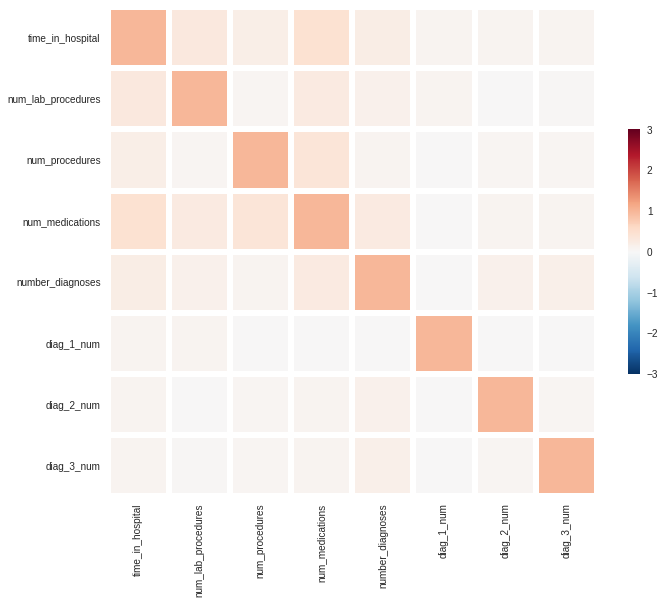

In [0]:
f, ax =plt.subplots(figsize=(11,9))
camp =sns.diverging_palette(220,10,as_cmap=True)
sns.heatmap(corr_matrix,vmax=3, center=0,square=True,linewidths=5,cbar_kws={"shrink":.5})



### Determinar qué par de variables están correlacionadas

In [0]:
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False))
# determinamos el threshold en 0.3 (corporativo)
th = 0.3
print(sol[abs(sol) > th])
lista_correlados = list(sol[abs(sol) > th].index)
lista_correlados

time_in_hospital  num_medications       0.466135
num_procedures    num_medications       0.385767
time_in_hospital  num_lab_procedures    0.318450
dtype: float64


[('time_in_hospital', 'num_medications'),
 ('num_procedures', 'num_medications'),
 ('time_in_hospital', 'num_lab_procedures')]

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


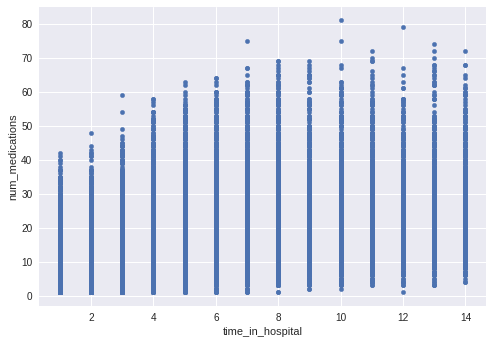

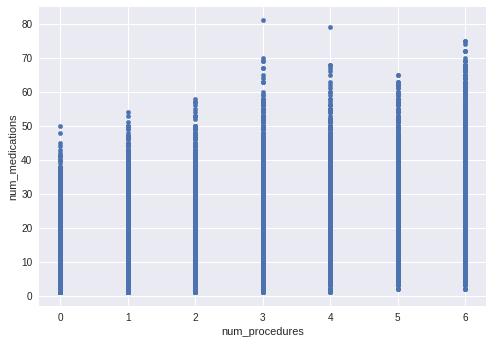

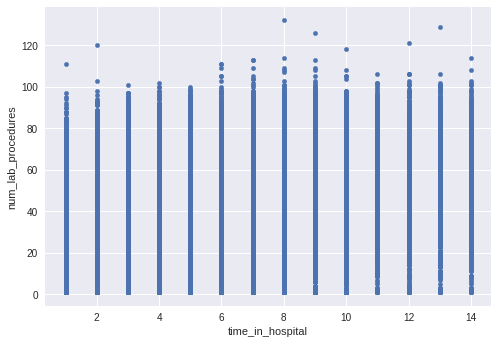

In [0]:
for var1,var2 in lista_correlados: #para cada uno, dibújame un scatter plot
    diabetes_to_EDA_numeric.plot(kind='scatter',
          x=var1,
          y=var2)

Para ver la relación entre variables cualitativas utilizamos tablas de contingencia

In [0]:
pd.crosstab(index=diabetes_to_EDA['age'], columns = diabetes_to_EDA['race'], margins = True).apply(lambda x: x/num_records*100, axis=1).plot(kind='bar')

In [0]:
pd.crosstab(diabetes_to_EDA['age'],diabetes_to_EDA['readmitted'],margins=True).apply(lambda x : x/num_records*100, axis=1)

readmitted,<30,>30,NO,All
age,,,,
[0-10),0.002948,0.025549,0.129709,0.158206
[10-20),0.039306,0.220113,0.419590,0.679009
[20-30),0.231905,0.501150,0.895191,1.628245
[30-40),0.416642,1.166401,2.126447,3.709490
[40-50),1.009178,3.221115,5.286638,9.516931
[50-60),1.639054,5.814319,9.503174,16.956547
[60-70),2.458581,7.759959,11.874300,22.092840
[70-80),3.015742,9.310575,13.289311,25.615628
[80-90),2.041939,6.115009,8.741623,16.898571
